In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.stats.qmc

In [2]:
def get_deflection_point(alpha,xi, F,l, E,I):
    
    beta = 1-alpha
    xi_ = 1-xi
    
    if xi <=alpha:
        return (1-beta**2-xi**2)*beta*xi*F*l**3/6/E/I
    else:
        return (1-alpha**2-xi_**2)*alpha*xi_*F*l**3/6/E/I

In [3]:
def get_deflection_curve(npoints, alpha, F, l, E, I):
    
    xi_vec = np.linspace(0,1,npoints,True)
    w_vec = np.empty_like(xi_vec)
    
    for i in range(npoints):
        w_vec[i] = get_deflection_point(alpha, xi_vec[i], F, l, E, I)
    
    return w_vec

### Simple example: maximum deflection of a simply supported beam ###

#### Output variable ####

The maximal deflection computed by the defleciton curve

$w(\xi) = (1-\beta^2-\xi^2) \beta \xi \frac{F l^3}{6 E I}$

where $\xi$ is the normalized $x$ coordinate and $\beta$ the point load position as a fraction along the beam


#### Parameters and unvertainties: ####

$\beta = \mathcal{N}(0.0005, 0.00002)$ - aleatory

$F = \mathcal{N}(1000, 40) \text{ N} $- aleatory

$l = 10.000 \text{ mm}$ - deterministic

$E = \mathcal{U}(0,1000)+\{8.000, 11.000\}  \text{ N mm}^{-2}$ - polymorphic

$I=80\times 10^6 \text{ mm}^4$ - deterministic

#### Propagation: ####

is done in an epistemic outerloop, for each focal set in the single epistemic variable and an aleatory inner loop, using Monte Carlo Techniques with $N=10000$

#### Results: ####

 Histograms and scatter plots for each focal set (orange and blue)

(array([2.69785215e-05, 2.66412899e-04, 1.30171366e-03, 4.55937013e-03,
       8.59265908e-03, 9.46946103e-03, 6.28262318e-03, 2.53598102e-03,
       6.13761363e-04, 7.41909340e-05]), array([ 844.55431647,  874.20753528,  903.86075409,  933.51397291,
        963.16719172,  992.82041053, 1022.47362934, 1052.12684815,
       1081.78006696, 1111.43328578, 1141.08650459]))


<IPython.core.display.Javascript object>


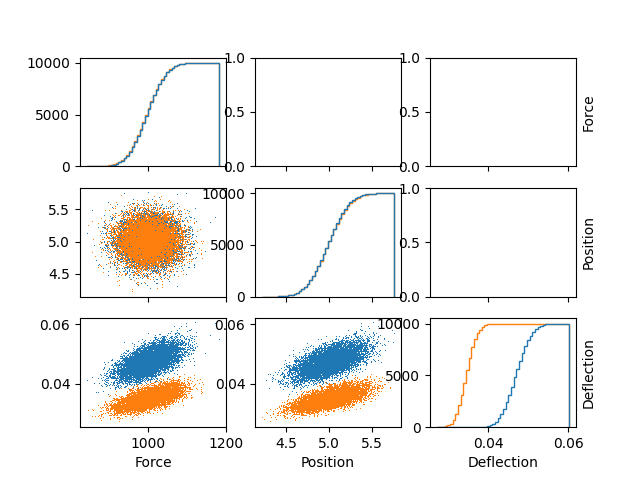

In [4]:
npoints = 25
alpha=.25
F=1000
l=10000
E=11000
I=80e6

nsamples = 10000


mu_F = 1000
var_F = 40
rand_vals= [[],[],[]]

for E in [8000, 11000]:
    E_vec = np.random.rand(nsamples)*1000+E
    F_vec = np.random.randn(nsamples)*var_F+mu_F
    a_vec = np.random.randn(nsamples)*0.2+5

    max_w_monte_carlo = np.empty_like(F_vec)

    for i in range(nsamples):

        w_curve = get_deflection_curve(npoints, a_vec[i]/l, F_vec[i], l, E_vec[i], I)
        max_w_monte_carlo[i] = max(w_curve)
    rand_vals[0].append(F_vec)
    rand_vals[1].append(a_vec)
    rand_vals[2].append(max_w_monte_carlo)
print(np.histogram(F_vec, density=True))

fig, axes = plt.subplots(3,3, sharex='col')

rand_labels = ['Force', 'Position', 'Deflection']
for i in range(3):
    axes[i,i].hist(rand_vals[i], bins=50, cumulative=True, histtype='step')
    for j in range(i):
        axes[i,j].plot(rand_vals[j][0],rand_vals[i][0], ls='none',marker=',')
        axes[i,j].plot(rand_vals[j][1],rand_vals[i][1], ls='none',marker=',')
    axes[-1,i].set_xlabel(rand_labels[i])
    axes[i,-1].yaxis.set_label_position("right")
    axes[i,-1].set_ylabel(rand_labels[i],rotation='vertical',)
plt.show()

### Verification example: analytical/numerical modal analysis ###

System: Vibrating rod, fixed-free boundaries
Input parameters and uncertainties:
- Young's modulus $E$: aleatory - e.g. due to environmental influences (temperature)
- Cross-sectional area $A$: epistemic - e.g. due to manufacturing tolerances
- Mass density $\rho$: aleatory - e.g. due to environmental influences (humidity)
- Length $L$: epistemic - e.g. due to manufacturing tolerances
- Degrees-of-freedom $n$: deterministic
- Rayleigh damping $\alpha$, $\beta$: polymorphic - aleatory due to natural material variability or environment and epistemic due to manufacturing tolerances
- (if needed additionally: boundary conditions)
    
Output parameters:
- modal frequencies: $\omega_1 \ldots \omega_? = \frac{2j-1}{2}\frac{\pi}{L}\sqrt{\frac{E}{\rho}}$
- modal damping: $\zeta_1 \ldots \zeta_? = \zeta = \frac{1}{2}\left(\frac{\alpha}{\omega}+\beta\omega\right) $
- FRF at length $x$ (also includes modeshapes) due to tip excitation: $\mathcal{H}_\mathrm{a}(\omega_\mathrm{f}) = \phi_j(x)\sum_j \frac{-\omega_j^2}{\kappa_j \left(1 + 2.0 i\zeta\frac{\omega_\mathrm{f}}{\omega_j}   - \left(\frac{\omega_\mathrm{f}}{\omega_j}\right)^{2} \right)} $
with $\phi_j(x) = \sin{\left(\frac{2j-1}{2} \frac{\pi}{L} x\right)}$
and $\kappa_j = \omega_j^2$

Proposed method: Second-Order Probability Analysis, two-stage Monte-Carlo Method with Cartesian input mass construction
- three approaches:
    - inner loop epistemic and outer loop aleatory (prefered)
    - inner loop aleatory and outer loop epistemic
    - threefold loops (either way)
    
Steps:
- define input mass and/or probability density functions
- define propagation function
- outer MCS loop: sample aleatory variables according to PDF
    - possibly compute parts of the output, which depend only on aleatory parameters
    - inner MCS loop: 
        - sample epistemic variables according to uniform distribution / regularly spaces?
        - compute output quantities (with aleatory and epistemic parameters)
    - find and store minima and maxima of outputs (could also be done in the inner loop, but better control is possible when precomputing results and postprocessing)
- draw histograms or minima and maxima

In [5]:
def mapping_function(E,A,rho,L,alpha,beta,fs,N,x):
    nyq_omega = fs / 2 * 2 * np.pi
    num_modes_ = int((nyq_omega * L / np.pi / np.sqrt(E / rho) * 2 + 1) // 2)
    
    j = np.arange(1, num_modes + 1, 1)    
    omegans = (2 * j - 1) / 2 * np.pi / L * np.sqrt(E / rho)
    zetas = 0.5 * (alpha / omegans + beta * omegans)
    
    omegas = np.fft.fftfreq(N, 1 / fs) * 2 * np.pi
    frf = np.zeros((N, ), dtype=complex)
    for mode in range(num_modes):
        omegan = omegans[mode]
        kappa = omegan**2
        modal_coordinate = np.abs(np.sin((2 * (mode + 1) - 1) / 2 * np.pi / L * x))
        frf += -omegan**2 / (kappa * (1 + 2 * 1j * zeta * omegas / omegan - (omegas / omegan)**2)) * modal_coordinate
        
    return omegans, zetas, frf    

epistemic parameters -> mass functions:
 - are a number of (focal) sets with associated degrees of belief
 - in the continuous case, sets become intervals or alike functionals defining a range of values, where each value is equally likely to be the "true" value
 - if different degrees of belief are assigned to sub-intervals, multiple subintervals must be defined
 
 - functional: $X \mapsto m$
   - where $X$ is a set or a functional defining a set of numbers, interval, etc. and assigned a mass value $m$ the total mass is assigned to a all $X$ and the remaining to $\Omega$
   
 - sampling: $m \mapsto X$ (select a set $X$ and the corresponding mass $m$)
   - sampling must be thought differently, since we define each focal sets with the intention of using that information,we should not disregard it again by not selecting it in a sampling process, then we could have "asked less experts"
   
 - propagation: 
   - we may choose to:
       - loop over focal sets individually to propagate individual expert knowledge to the output or 
       - combine all focal sets into a (possibly lower) number of new focal sets prior to propagation
   - for each focal set in X:
     - propagate each element in the focal set to $Y$ (or estimate a continuous functional defining $Y$ (e.g. an interval))
     - assign $m_X = m_Y$
     - a mass function: $Y \mapsto m_Y$ is obtained and can be plotted, e.g. as intervals at their respective mass levels
   - multiple inputs $(X_1, X_2, ...) \mapsto Y$:
     - in fuzzy-type mass functions we can define an $\alpha$-level and sample $X_1$, $X_2$, $\ldots$ at their $\alpha$-levels then assign that $\alpha$-level to $Y$
     - for general MassFunctions, all combinations of input focal sets must be computed (Cartesian Product Propagation -> Hypercubes) $A\times B = \{(a,b)\mid a \in A \ \mbox{ and } \ b \in B\}$
       - therefore the number of focal sets for each input should be kept as low ass possible ("ask only 1 to 3 experts")
       - or computer propagate only high-mass hypercubes
       - the mass of the results will be product of the masses of input focal sets
    - for continuous input focal sets, i.e. intervals, continuous output focal sets are assumed -> interval optimization
      - an interval optimization is approximated by Monte Carlo Techniques due to:
        - possibly noise mapping functions
        - multiple outputs
        - multidimensional outputs, that are not directly comparable
        - guaranteed convergence in a limited amount of time
        - the qualitative effect of epistemic uncertainties is more of interest than a highest possible precision of uncertainty propagatio
       - since we assume no value is more or less likely in an input interval, we propagate that assumption to the output intervals, even though the mapping function might lead to different distributions of output values
       - input intervals will be sampled by random distributions to avoid effects related to non-independentness or regular spacing of inputs
         - in order to capture best the behaviour at the interval boundaries an appropriate sampling distribution should be chosen i.e. uniform, arcsine or U-quadratic distribution
    


    
aleatory parameters -> random variables, defined by a PDF/PMF type and parameters
 - these are methods of the 'np.random.rng' Class
 - mass functions are PDFs if their focal sets consist of only singletons and $\sum m_i =1$
 - PDFs can be approximated by Mass functions, by dividing them into several subintervals, however, this will lead to a large number of hypercubes to be propagated 
  
 - functional: 
   - $x \mapsto p$ (defined for every $p \in [0,1]$)
   
 - sampling (using the inverse): 
   - $p \mapsto x$ (where $p$ is a randomly selected number from $[0,1]$)
 - sampling (uniform)
   - obtain the support of the PDF and sample uniform random values 
   - assign probability to each sampled value and pass through propagation 
   - that allows for slight modifications retrocatively
   
 - propagation: 
   - analytical through the mapping function, usually impossible
   - approximation by Monte Carlo Techniques 
       - sample $N$ values from the distribution and propagate them through the mapping function 
       - compute the relevant statistics/Parameters of PDFs from the output samples
   - alternatively using quasi monte carlo techniques
       - sample $N$ values from a uniform distribution on the support and propagate them through the mapping function
       - propagate the probability product of each sample to the output
       - compute weighted statistics/parameters
   

difference:
 - "PMFs/PDFs assign beliefs to singletons/continuous values where MassFunctions assign beliefs to sets/intervals"

polymorphic parameters -> part of the uncertainty is due to natural variablity and another part due to incomplete, imprecise or no knowledge
 - sampling and propagation must take part in the order of the nesting of aleatory and epistemic components
 - in the worst case a threefold nested loop will be required, where only in the innermost loop the full parameter set for the deterministic mapping function will be available, e.g.
   - aleatory (MCS) -> epistemic (interval optimization / MCS) -> aleatory (MCS)
   - epistemic (interval optimization / MCS) -> aleatory (MCS) -> epistemic (interval optimization / MCS)
 - if uniform sampling over the support of each variable is used and probabilities/masses are assigned retroactively
     - samples can be pregenerated: cartesian product of aleatoric and epistemic samples, single parallel loop can be used
     - Number of samples can be extended
     - Support of variables is fixed

 - epistemically uncertain random variables: 
   - the parameter is distributed randomly according to PMF/PDF with parameters x to a certain degree of belief y
   - parameters are defined by mass functions

   - functional:
     - $X \mapsto m$ for all $X \in \Omega$
     - $x \mapsto p$ for all $x \in X$
     
   - sampling:
     - sample parameter(s) from mass function(s)
     - build PDF/PMF
     - sample value vom PDF/PMF

   - propagation:
     - for each focal set:
       - for each value in focal set / interval optimization: (i.o. -> find the values from the focal set that maximize and minize the output)
         - build PMF/PDF
         - for $n_a$ in $N_a$ (Monte Carlo Sampling): 
           - sample value from PMF/PDF
           - propagate through mapping function $Y$
         - compute statistics of interest (mean, var, min, max, other)
       - build output focal set from collected statistics and assign the respective mass to it

 - randomly defined mass functions: 
   - the parameters of a mass function are Random Variables, e.g. the interval boundaries are RVs

   - functional:
     - $X \mapsto p$ for all $X \in \Omega$ ?
     - $x \mapsto m$ for all $x \in X$

   - sampling:
     - sample parameter(s) x from RandomVariable(s) X
     - build focal set and assign a mass to it (how to choose this mass?)
     - sample value from focal set

   - propagation:
     - for $n_a$ in $N_a$ (Monte Carlo Sampling):
       - sample parameters from RandomVariables
       - build focal set and assign a mass to it (how to choose this mass?)
       - for each value in focal set / interval optimization:
         - propagate through mapping function $Y$
       - build output focal set from output values and assign the respective mass to it
     - compute statistics over the focal sets, e.g. histograms of interval boundaries (masses act as weights?)
  
  - randomly defined mass functions that define a random variable:
    - the equivalent of "Fuzzy probability based fuzzy random variable"
     
distinguish:

probability space: $(\Omega, \Sigma, P)$ (define the set of all values, the set of all subset (or continuous intervals) of all values, and a probability measure)

Random Variable: $X: \Omega \mapsto \mathbb{R}$ (picks a single value fom $\Omega$)

Probability measure: $P_X: \mathcal{B}(\mathbb{R}) \mapsto [0,1]: I \mapsto P_X(I) = P(X^{-1}[I])$ (assign each element/set in $\Sigma = \mathcal{B}(\mathbb{R})$ (?) a number in $[0,1]$)

Probability density function: $P_X(I) = \int_I f_X(t)d(t)$ (actually $f_X$ is the pdf )

<IPython.core.display.Javascript object>


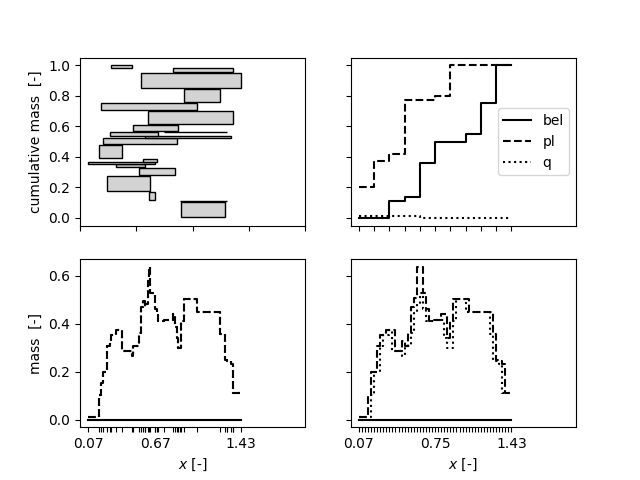

0.46652060738669454 0.46652060738669454 0.0
0.4909200821260228 0.4400968013041634 0.0
0.9923466581333262 0.005388455347688324 0.5283708996319157


'\ncreate example with ~20 focals\nshowing the properties below:\naligned non-cumulative/not-aligned many non-cumulative/not-aligned few cumulative\n\n\npl == q if bins are aligned with focal sets\nq <= pl if bins are not aligned with focal sets\nbel <= q <= pl \nfor large focal sets / small bins bel is mostly 0\n\nfor cumulative measures \nq is mostly 0 (useless measure)\nbel < pl for overlapping focal sets\n'

In [316]:
%matplotlib notebook
random_sets = True
sort=False
nfocals=20
cumulative = False
nbins = None # set None to use aligned bins

if not random_sets:
    mass = np.diff([0,0.4,0.7,1.3,1.7,2.7,3,3.6,3.8,4,4.2,4.5])
    focals = np.array([(0.7,3),(1.2,4),(1.3,1.8),(1.7,3.3),(0.7,4.8),(1.7,4.3),(2.4,3.9),(3,3.7),(3.3,5.1),(1.2,3.7),(2.5,3.2)])
    nfocals = mass.size
else:
    mass = np.random.random(nfocals)
    focals = np.empty((nfocals,2))
    focals[:,0] = np.random.random(nfocals)
    focals[:,1] =  focals[:,0] + np.random.random(nfocals)

if sort:
    sortinds = np.flip(np.argsort(mass))
    mass =mass[sortinds]
    focals = focals[sortinds,:]
    
mass /= mass.sum()

# plot focal sets and masses
fig, axes = plt.subplots(2,2, sharex=False, sharey='row')
ax1,ax2,ax3,ax4 = axes.ravel()

def plot_focals(focals, mass, ax=None):
    if ax is None: _,ax = plt.subplots()
    cm=0
    for (l,r),m in zip(focals,mass):  
        ax.bar(l,m*0.9,(r-l),bottom = cm+0.05*m, align='edge', color='lightgrey', edgecolor='black')
        cm += m
    ax.set_xticks([0,0.5,1,1.5,2])
    ax.set_xticklabels(['','','','','',])
    
    return ax

plot_focals(focals, mass, ax1)
    
for nbins, cumulative, ax in zip([None, 51, 11], 
                                 [False, False, True], 
                                 [ax3, ax4, ax2]):

    if nbins is None:
        bins = np.sort(focals.ravel())
    else:
        bins = np.linspace(focals.min(), focals.max(), nbins)

#     ax.vlines(bins, 0, 1, color='grey', ls='dashed',  lw=1)
    bel = np.zeros(bins.size)
    pl = np.zeros(bins.size)
    q = np.zeros(bins.size)

    # Bins are set A
    # focals are set B or C
    for i in range(bins.size - 1):
        # set A
        lbin, ubin = bins[i:i+2]
        if cumulative:
            lbin = focals.min()

        # get all sets B that are a subset of A
        # that means the lower boundary of B must be greater or equal than the lower boundary of A
        # and similarly for the upper boundary
        belinds = np.logical_and(focals[:,0] >=lbin,
                                 focals[:,1] <= ubin)
        bel[i] = np.sum(mass[belinds])
        # get all sets B that intersect with A
        # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
        # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
        plinds = np.logical_and(focals[:,0]<ubin, 
                                focals[:,1]>lbin, )
        pl[i] = np.sum(mass[plinds])

        # get all sets B that are a superset of A   (=A is a subset of B)
        # that means the lower boundary of A must be greater or equal to the lower boundary of B
        # and similarly for the upper boundary
        qinds = np.logical_and(focals[:,0] <= lbin,
                               focals[:,1] >= ubin)   
        q[i] = np.sum(mass[qinds])

    bel[-1]=bel[-2]
    pl[-1]=pl[-2]
    q[-1]=q[-2]
    
    print(np.sum(pl[:-1]*np.diff(bins)), np.sum(q[:-1]*np.diff(bins)), np.sum(bel[:-1]*np.diff(bins)))

    
    ax.step(bins, bel, c='k', where='post', label='bel', ls='solid')
    ax.step(bins, pl, c='k', where='post', label='pl', ls='dashed')
    ax.step(bins, q, c='k', where='post', label='q', ls='dotted')
    ax.set_xlim((0,2))
    ax.set_xticks(bins)
    ticklabels= ['' for _ in range(bins.size)]
    ticklabels[0] = f'{bins[0]:1.2f}'
    ticklabels[-1] = f'{bins[-1]:1.2f}'
    ticklabels[bins.size//2] = f'{bins[bins.size//2]:1.2f}'
    ax.set_xticklabels(ticklabels)
                
ax2.legend()
ax2.set_xticklabels(['' for _ in ax2.get_xticks()])
ax1.set_ylabel('cumulative mass  [-]')
ax3.set_ylabel('mass  [-]')
ax3.set_xlabel('$x$ [-]')
ax4.set_xlabel('$x$ [-]')
# ax1.set_title('focal sets')
# ax2.set_title('cumulative belief functions (few regular bins)')
# ax3.set_title('belief functions (aligned bins)')
# ax4.set_title('belief functions (many regular bins)')


'''
create example with ~20 focals
showing the properties below:
aligned non-cumulative/not-aligned many non-cumulative/not-aligned few cumulative


pl == q if bins are aligned with focal sets
q <= pl if bins are not aligned with focal sets
bel <= q <= pl 
for large focal sets / small bins bel is mostly 0

for cumulative measures 
q is mostly 0 (useless measure)
bel < pl for overlapping focal sets
'''

### Types of uncertainty and how to model them: ###

#### variability: ####
  * description: natural variation of a parameter, which cannot be reduced 
  * modeling: assuming exact description of variability properties -> probability distributions, 
  * outcome: (single loop: aleatory)
      * estimate statistics: most likely value + confidence intervals, probabilities of exceedance, 
      * bin the output and for each bin compute the probaility density
  * visualization: 
      * tables for scalar values
      * empirical CDFs (histograms), 
  
#### incompleteness: ####
  * description: approximate knowledge of the variability properties, distribution parameters can not be exactly determined due to insufficient number of samples
  * modeling: assume different ranges for distribution parameters to which we assign mass (=degree of belief)
  * outcome (outer loop: epistemic, inner loop: aleatory):     
      * for each epistemic sample
          * evaluate aleatory samples to get scalar or multi-valued (probability densities on bins) statistics
      * for each input hypercube
          * do interval optimization on the scalar / multi-valued statistics and assign mass
      * bin the statistics and for each bin
          * compute bel, pl and q (how much mass supports precisely the bin)
  * visualization: 
      * bar plots for statistics width=mass
      * plot bel, pl and q of scalar statistics
      * plot histograms with pl/q as colormap on the probability axis (similar to upper and lower probabilities (pboxes))

#### imprecision: ####
  * description: approximate knowledge of a parameter, which is assumed invariable, due to imprecise measurements
  * modeling: choose different ranges and assign degrees of belief
  * outcome: (single loop: epistemic)
      * ranges on the output with associated masses (for each input hypercube)
      * bin the output space and compute bel, pl and q functions on these bins
  * visualization (see example below): 
      * horizontal bar plots on the ranges and width = mass (sums up to 1) (one bar for each input hypercube)
      * plot bel, pl and q  

#### additional types of uncertainty: ####
  * vagueness, (fuzzyness OR epistemicist view: vague predicates do, in fact, draw sharp boundaries, but that one cannot know where these boundaries lie)
  * ambiguity,  (outcomes are unknown, because one can not predict which outcome will be realized, more research may increase uncertainty, new evidence will contradict existing knowledge)
  * indeterminacy,  (causal chains are open, opposed to determinacy; complexity of what is studied, existence of nonlinear relations, knowledge can not be used to make predictions, systemic changes, )
  * Ignorance (unknown outcomes - we don't knwo what we don't know [Black swan problem, Faulty generalization])
  * dubiety, (a generally hesitant uncertainty or doubt that tends toward indecision / to cause vacillation )
  * subjective experience, 
  * expert knowledge,    

### Modeling strategies for combined types of uncertainty / polymorphic uncertainty as defined by TU DD Group: ###

#### VAR + IMP (Fuzzy-Randomness): ####
  * description: a range of values, whose boundaries are variable
  * modeling: define a probability distribution, which operates on sets/ranges
  * outcome: 
      * estimate set-valued statistics: 
          * most likely set/range + confidence intervals (how?),  
          * probabilities of exceedance (how?), 
          * bin counts (how?), 
          * etc.
      * that all requires sets to be orderable -> fuzzy sets
  * simplification/alternative: sets which are bound by probability distributions
  * outcome (outer loop: aleatory, inner loop: epistemic): 
      * uncertain bel, pl and q curves (fixed bins, variable values)
      * for each aleatory sample
          * for each epistemic sample in the hypercube
              * do interval optimization on the output quantity and assign mass
          * bin the output and for each bin
              * compute bel, pl and q
      * compute statistics for bel, pl and q and each epistemic bin
  * visualization: 
      * plot bel, pl and q with vertical lines color shading proportional to probability density


#### VAR + INC (Fuzzy probability based randomness): ####
  => incompleteness
  
#### INC + VAR + IMP (Fuzzy-probability based fuzzy randomness): ####
  * description: a range of values, whose boundaries are variable and incompletely known
  * define variables by name that may reference others (polymorphic)
  * assign propagation_stages to variables:
      pure epistemic (imprecision): stage_3
      pure aleatory (variability): stage_2
      epistemic + aleatory (incompleteness): stage_1 (stage 2)
      aleatory + epistemic:: stage_2 (stage 3)
  * compute support/frame of each variable to define the **sample space**
  * Building a 2D or a 3D sample space?
      * 3D: individually sample incomplete, variable and imprecise variabels and combine them full-focatorial
          * for each aleatory sample an interval optimization is to be performed
          * for each epistemic sample a monte carlo simulation is to be performed
          * that means in a threefold loop we choose an epistemic sample, then choose an aleatory sample and need a sufficient number of epistemic samples again to do the inner loop interval optimization
          * a threefold nesting of low-discrepancy sequences is required according to the stages of the variables
      
      * 2D: since we consolidate foc_imp and foc_inc we should be able to "simulate" the both epistemic loop in a single run
      * Example: 
          * sample incomplete variables and supplement a sample of imprecise variables
          * perform MCS on aleatory variables and store the CDF
          * go to the next sample
          * eventually we cover the whole range of incomplete and imprecise variables and have a CDF for each sample
          * which is presumably not much different from the original approach but much more efficient
      * try that with the example from Pannier
  * assign id_ale and id_epi to respective samples for storing intermediate results (see below)
  * Further performance improvements:
  * reuse independent steps of the mapping function
  * define steps of the mapping function e.g. structural dynamics, signal processing, system identification and modal analysis
  * make the first step(s) pure aleatory is the only option here since all further steps depend on uncertain input from the previous steps which will not be pure aleatory or pure epistemic anymore then; 
      * uncertain inputs: 
          * noise excitation is unknown and random (aleatory random field + process),
          * noise excitation amplitude can be estimated roughly (incomplete output but aleatory input), 
          * impulse excitation DOFs are known to some extent by the pracitioner, but their relation to the modeshapes can only be estimated roughly (define an imprecise modeshape relation), 
          * impulse excitation spectra depend on the hammer tip, the impact point stiffness and other factors and can be rouhgly estimated from the datasheets (define a probability distribution on the excitation spectrum, the choice of an appropriate spectrum out of a few is however imprecise), 
          * impulse times are modeled as a random process (aleatory)
      * certain inputs (exemplary evaluation for different structures: rod, beam, 3D beam, nonlinear rod, nonlinear 3D beam)
          * mass, stiffness, damping (rayleigh)
          * number of nodes (system order)
          * deltat (small enough -> downsampling in signal processing)
          * timesteps (enough -> shorten in sig-proc)
          * output DOFs (all -> reduce in sig-proc)
          * nonlinearities (together with uncertain inputs will result in uncertain (linearized) system properties)
    

In [483]:
from itertools import product

class UncertainVariable(object):
    '''
    Implementation of various types of uncertain variables
    to be used with uniform quasi-random sampling over the support
    that is why they can not be directly sampled
    '''
    def __init__(self, name, primary=True):
        self.value = None
        self.name = name
        self.primary = primary
        
    def support(self, ):
        '''
        getting the support is usually needed in pre-processing, before propagation
        no frezzing is necessary, simply evaluating the minimal and maximum values possible
        '''
        raise NotImplementedError("When subclassing UncertainVariable you should implement a support() method.")
        
    
    def mass(self, value=None):
        # for nested uncertain variables, inner variables must be frozen in order to realize the outer variables 
        # return mass-values or probabilities for a given value

#         if value is None:
#             value = self.value
        pass
    
    def freeze(self, value):
        # fix variable, make it a "CertainVariable"
        self.value = value
    
    def unfreeze(self, ):
        self.freeze(None)
        
    @property
    def frozen(self, ):
        return self.value is not None
    
class RandomVariable(UncertainVariable):
    
    def __init__(self, dist, name, params, primary=True):
        super().__init__(name, primary)
        self.dist = dist
        self.dist_fun = getattr(scipy.stats, self.dist)
        self.params = params
    
    def support(self, percentiles=(0.001,0.999)):
        eval_params = []
        for param in self.params:
            if isinstance(param, UncertainVariable):
                param = param.support(percentiles=percentiles)
            if isinstance(param, (float, int)):
                param = [param]
            eval_params.append(param)
        supp = [np.infty, -np.infty]
        for params in product(*eval_params): # nested for loop over all eval_params -> cartesian product = full factorial
            rv = self.dist_fun(*params)
            this_supp = rv.ppf(percentiles)
            supp[0] = min(supp[0], this_supp[0])
            supp[1] = max(supp[1], this_supp[1])
        return supp
    
    def mass(self, values=None):
        super().mass(values)
        # we need to have all uncertain parameters fixed
        eval_params = []
        for param in self.params:
            if isinstance(param, UncertainVariable):
                if not param.frozen:
                    raise RuntimeError(f"Variable {param.name} is not frozen.")
                eval_params.append(param.value)
            else:
                eval_params.append(param)
        rv = self.dist_fun(*eval_params)
        pdf = rv.pdf(values)
        return pdf / pdf.sum()

class MassFunction(UncertainVariable):
    # currently only continuous-valued belief functions are supported
    # may be extended to set-valued belief functions 
    # Another Class fur fuzzy sets may be created, exposing the same set of methods
    '''
       - properties such as frame, core, bel, pl, q, focal, singletons, 
   - transformations: pignistic, normalize, inverse pignistic (defining a mass function from samples)
   
   incremental focal sets should be implemented, this is important for polymorphy only
       implement internal storage of incremental focals sets
           return non-incremental focal sets
           
    '''
    
    def __init__(self, name, focals, masses, frame=None, primary=True, incremental=False):
        super().__init__(name, primary)
        
        if not isinstance(focals, np.ndarray): # note, it may contain objects
            focals = np.array(focals)
        if not isinstance(masses,  np.ndarray):
            masses = np.array(masses)
        
        assert focals.shape[1] == 2
        assert focals.shape[0] == masses.shape[0]
        
        total_mass = np.sum(masses)
        if total_mass > 1:
            raise ValueError(f'The sum of all mass values ({total_mass}) must not be greater than one.')
        if  total_mass < 1:
            if frame is None:
                raise ValueError("If unassigned mass remains, the frame must be specified")
            focals = np.vstack([focals, frame])
            masses = np.vstack([masses, [1 - total_mass]])
        
        self.incremental = incremental
        self.focals = focals
        self.masses = masses
        self.frame = frame
    
    @property
    def n_focals(self,):
        return self.focals.shape[0]
    
    def numeric_focals(self,):
        # evaluates all focal sets to numeric values
        # raises error if nested UncertaunVariables are not frozen
        
        incremental = self.incremental
        focals = self.focals
        numeric_focals = np.empty(focals.shape)
        for i in range(self.n_focals): # iterates over rows
            lbound, ubound = focals[i, :]
            
            if isinstance(lbound, UncertainVariable):
                if not lbound.frozen:
                    raise RuntimeError(f"Variable {lbound.name} is not frozen.")
                lbound = lbound.value
                            
            if isinstance(ubound, UncertainVariable):
                if not ubound.frozen:
                    raise RuntimeError(f"Variable {ubound.name} is not frozen.")
                ubound = ubound.value
            
            if incremental:
                ubound += lbound
                
            numeric_focals[i, :] = lbound, ubound
                
        return numeric_focals
    
    def support(self, *args, **kwargs):
        incremental = self.incremental
        focals = self.focals
        supp = [np.infty, -np.infty]
        for lbound, ubound in focals: # iterates over rows
            '''
            iterate over lower and upper boundary in focal set and 
            extend support if either extends the current support range
            
            if boundaries are defined by UncertainVariables
            '''
            
            if isinstance(ubound, UncertainVariable):
                usupp = ubound.support()
                ubound = usupp[1]
            
            if isinstance(lbound, UncertainVariable):
                lsupp = lbound.support()
                if incremental:
                    ubound += lsupp[1]
                lbound = lsupp[0]
            elif incremental:
                ubound += lbound
            
            supp[0] = min(supp[0], lbound)
            supp[1] = max(supp[1], ubound)

        return supp
    
    def mass(self, value=None):
        super().mass(value)
        # only single values may be provided        
        # value may be in more than one focal set, bel and pl are better used instead
        # may return multiple or no mass values
        numeric_focals = self.numeric_focals()
        
        masses = self.masses
        inds = np.logical_and(numeric_focals[:,0] >=value,
                              numeric_focals[:,1] <=value)
        return masses[inds]
    

mu1 = MassFunction(name='mu1', focals=[(14.78,14.80),(13.96,15.61)], masses=[0.5,0.5], primary=False)
sig1 = MassFunction(name='sig1', focals=[(4.16,4.18),(3.66,4.85)], masses = [0.5, 0.5], primary=False)
q1 = RandomVariable(name='q1', dist='norm', params=[mu1, sig1])
display(q1.support())

inc_q1a1 = (RandomVariable(name='q1a1l', dist='norm', params=[15,4], primary=False),
          RandomVariable(name='q1a1l', dist='norm', params=[0.1,0.01], primary=False),)
inc_q1a0 = (RandomVariable(name='q1a0l', dist='norm', params=[14.6,np.sqrt(4**2 + 0.06**2)], primary=False), 
          RandomVariable(name='dq1a0r', dist='norm', params=[0.9,np.sqrt(0.06**2 + 0.1**2)], primary=False))
q1 = MassFunction(name='q1', focals=[inc_q1a1, inc_q1a0], masses=[0.5,0.5], primary=True, incremental=True)
display(q1.support())


[-1.0276266849138924, 30.59762668491389]

[2.237680249003679, 28.222699669419548]

### Examples from Pannier et al. ###

mapping: $f(q_1,q_2) = (\frac{189}{500} q_1 + 3 q_2) \frac{16}{3} > 260 $

number of Monte Carlo samples: 1 000 000

In [84]:
def deterministic_mapping(q1,q2,sigma_max=260):
    return deterministic_mapping2(q1,q2)>sigma_max
def deterministic_mapping2(q1,q2):
    return (189/500*q1+3*q2)*16/3
N_mcs = int(1e6)

<IPython.core.display.Javascript object>


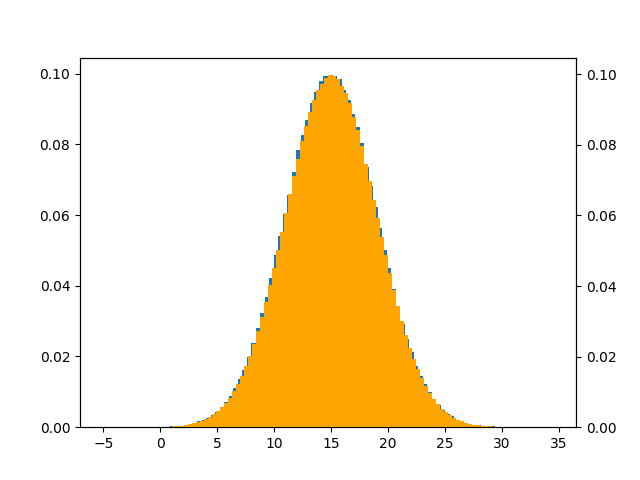

<IPython.core.display.Javascript object>


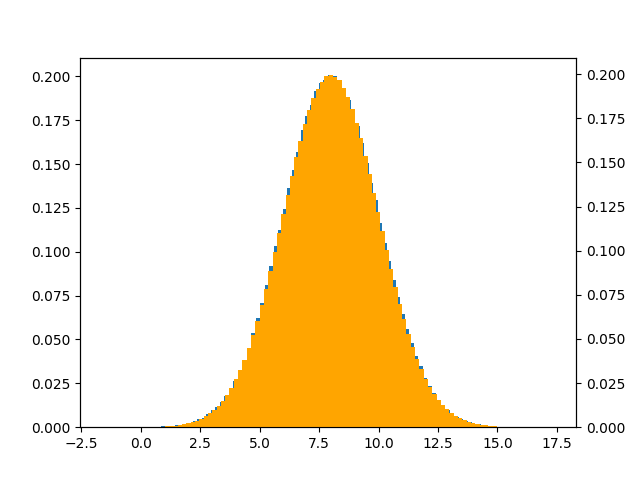

<IPython.core.display.Javascript object>


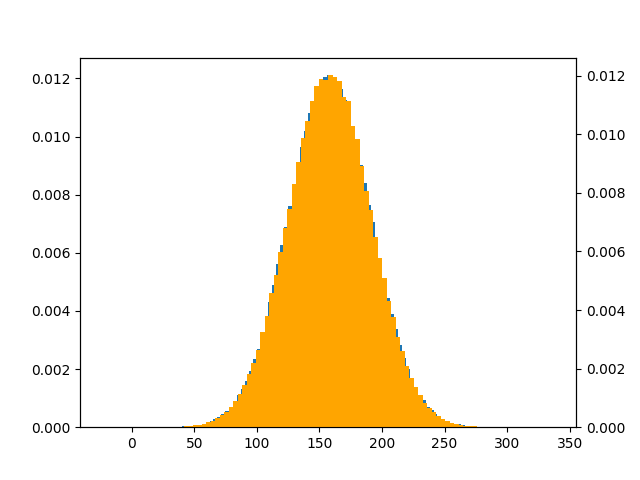

'1.06 x 10^-3'

In [85]:
#a) Random Variables (pure aleatory)
m_q1 = 15
s_q1 = 4
m_q2 = 8
s_q2 = 2
F_q1 = scipy.stats.norm(m_q1, s_q1)
rvsq1 = F_q1.rvs(N_mcs)
_,ax1 = plt.subplots()
ax1.hist(rvsq1, bins=100, density=True, cumulative=False)
ax1 = ax1.twinx()
F_q2 = scipy.stats.norm(m_q2, s_q2)
rvsq2 = F_q2.rvs(N_mcs)
_,ax2 = plt.subplots()
ax2.hist(rvsq2, bins=100, density=True, cumulative=False)
ax2 = ax2.twinx()
res = deterministic_mapping2(rvsq1,rvsq2)
_,axres = plt.subplots()
axres.hist(res, bins=100, density=True, cumulative=False)
axres = axres.twinx()


res = res > 260
Pf = np.sum(res)/N_mcs
display(f'{Pf*1000} x 10^-3')

In [87]:
#b) fuzzy random variable

# definition of fuzzy distribution parameters
m_q1 = [14.6, 15.0, 15.5]
s_q1 = [np.sqrt(4**2+0.1**2), 4.0, np.sqrt(4**2+0.06**2)] # note that the "peak" value is lower than both boundaries

m_q2 = [7.4, 8.0, 8.4]
s_q2 = [np.sqrt(2**2+0.08**2), 2.0, np.sqrt(2**2+0.11**2)] # note that the "peak" value is lower than both boundaries

# initialization of fuzzy-failure probability (output)
Pf = [1,None,0]

# alpha = 1 (fuzzy singleton)
F_q1=scipy.stats.norm(m_q1[1],s_q1[1])
F_q2=scipy.stats.norm(m_q2[1],s_q2[1])
res = deterministic_mapping(F_q1.rvs(N_mcs),F_q2.rvs(N_mcs))
Pf[1] = np.sum(res)/N_mcs

In [88]:
# interval optimization by naive full factorial assuming minimax will occur at the boundaries
for boundary_q1 in [0,2]:    
    Dm_q1_ = m_q1[boundary_q1] - m_q1[1]
    Ds_q1_ = np.sqrt(s_q1[boundary_q1]**2 - s_q1[1]**2)
#     print(Dm_q1_, Ds_q1_)
    DF_q1 = scipy.stats.norm(Dm_q1_, Ds_q1_)
    
    for boundary_q2 in [0,2]:
        
        Dm_q2_ = m_q2[boundary_q2] - m_q2[1]
        Ds_q2_ = np.sqrt(s_q2[boundary_q2]**2 - s_q2[1]**2)
#         print(Dm_q2_, Ds_q2_)
        DF_q2 = scipy.stats.norm(Dm_q2_, Ds_q2_)
        #F_q2=scipy.stats.norm(m_q2[boundary_q2],s_q2[boundary_q2])
        
        RVs_q1 = F_q1.rvs(N_mcs) + DF_q1.rvs(N_mcs)
        RVs_q2 = F_q2.rvs(N_mcs) + DF_q2.rvs(N_mcs)
        res = deterministic_mapping(RVs_q1,RVs_q2)
        Pf_ = np.sum(res)/N_mcs
        if Pf_ < Pf[0]:
            Pf[0] = Pf_ 
#             print(f'min {boundary_q1},{boundary_q2}')
        if Pf_ > Pf[2]:
            Pf[2] = Pf_
#             print(f'max {boundary_q1},{boundary_q2}')
display([p*10000 for p in Pf])
            

[3.38, 10.25, 19.61]

#### POST-PROCESSING computed output samples ####
  * construct incomplete variables (from polymorphic inputs, INC does not exist for pure epistemic) -> V_inc
  * **evaluate incompleteness** (Interval optimization Part I)
      * sample monomorphic variables -> S_inc
      * sample distribution parameters (polymorphic variables) 
      * construct random variables (from pure aleatory and polymorphic inputs) -> V_var
      * **evaluate variability** (Monte Carlo Simulation)
          * sample random values monomorphic variable -> S_var
          * sample random values polymorphic variables 
          * construct imprecise variables (from pure epistemic and polymorphic inputs) -> V_imp
          * **evaluate imprecision** (IO Part I)
              * sample imprecise variables -> S_imp
              * evaluate mapping function S_inc, S_var, S_imp -> S_out[N_mcs_epi, n_out]
          * for each hypercube in V_imp (IO Part II) -> n_hyc_imp
              * compute intervals/focal sets of output (for n_out variables in S_out)
              * assign mass product
          * -> Mass_imp [n_hyc_imp, n_out]
          * -> Foc_imp [n_hyc_imp, 2, n_out]
      * (MCS Part II)compute statistic on each Foc_imp (All_Foc_Imp [N_mcs_ale, n_hyc_imp, 2, n_out] e.g. 
          * upper and lower average output value n_stat=1
          * upper and lower confidence intervals of output value n_stat=2
          * upper and lower failure probability n_stat=1
          * upper and lower probability density for each aleatory bin n_stat=20
          * **Problem**: Probability weights get lost/mixed up in previous interval optimization, even though, they only depend on the outermost loop, in 2D sampling innermost and outermost loop are combined
      * -> Stat_Foc_imp [n_stat * n_hyc_imp, 2, n_out]
   * for each hypercube in V_inc (Interval optimization Part II) -> n_hyc_inc
       * compute intervals/focal sets of each n_stat statistic for each boundary of each hypercube in n_hyc_imp
       * assign mass product
   * -> Foc_inc_Stat_Foc_imp [n_hyc_inc * n_stat * n_hyc_imp, 2_inc , 2_imp , n_out]
   * -> Mass_inc x Mass_imp [n_hyc_inc * n_hyc_imp,  n_out ]
   * consolidate imp-inc hypercubes?
       * now, we have for each of the n_hyc_inc hypercubes twice (upper_inc, lower_inc) a number of n_hyc_imp statistics (e.g. failure probabilities, CDF curves) twice (upper_imp, lower_imp)
       * let's consider the interval length as sensitivity with regard to the input hypercube sens_.. = upper_.. - lower_..
       * cases: (per epistemic hypercube)
           * no imprecision: upper_imp==lower_imp
           * no incompleteness: upper_inc==lower_inc
           * no variability: statistic==const. (this does not matter here)
           * sens_imp > sens_inc OR sens_inc > sens_imp OR sens_inc~sens_imp: 
               * in any case low-low / high-high are the boundaries and low-high / high-low move in between
       * -> reduce to low-low / high-high + sens_imp / sens_inc
       * n_hyc_cons = n_hyc_inc * n_hyc_imp
   * Foc_Stat_cons [n_hyc_cons * n_stat , 2 , n_out]
   * (Sens_imp [n_hyc_cons * n_stat , n_out], Sens_inc  [n_hyc_cons * n_stat , n_out])
   * derive other belief functions:
   * for each stat in n_stat: (e.g. for each aleatory bin)
       * bin the range of stat (e.g. range of mean values, range of failure probabilities, range of probability densities)
       * (possibly use the same bins for comparable statistics)
       * for each bin:
           * compute bel, pl and q form the n_hyc_cons hypercubes and corresponding Mass_cons values
           * for cumulative statistics -> use non-cumulative belief functions
           * for non-cumulative statistics -> use cumulative belief functions
       * plot belief functions of scalar statistics
   * plot multi-valued statistics with belief function color shading
   
   * special cases to consider (later):
       * in case of no variability: only imprecision Foc_Stat_cons = Stat_Foc_imp = Foc_imp
       * in case of no imprecision: Foc_imp = S_out
       * in case of no incompleteness: -> see no variability
           
      
      
What is of interest here is:
   * outer-most loop: incompleteness leads to intervals of distributed interval valued outputs
   * middle loop: variability leads to distributed interval valued outputs
   * inner-most loop: imprecision leads to interval valued outputs
   * in total: families of distributed interval valued outputs
   * inner-most loop: for each imprecise input hypercube -> compute belief function (interval boundaries :-> mass)
   * middle loop: alternatives
       * compute the distribution of the interval boundaries (for each imprecise input hypercube) (distributed interval boundaries -> mass)
       * compute bel,pl,q for bins distributed over output range; compute distributions of bel,pl,q for each bin
   * outer-most loop: for each incomplete input hypercube -> compute the upper and lower probability distribution of each interval boundary of imprecise input hypercubes (-> mass product)
    
   * n_inc x n_imp upper and lower probabilities 
 das

In [462]:
def generate_hypercubes(vars_epi, samples=None, N_mcs_epi=None, overview=True):
    # cartesian product of input intervals / focal sets
    # for fuzzy sets, an alpha level is chosen, which results in a single focal set per variable -> single hypercube
    hyc_foc_inds = list(product(*[range(var.n_focals) for var in vars_epi])) # for each hypercube: indices of focal sets of each variable
    n_hyc = len(hyc_foc_inds)
    
    if overview:
        hyc_ovrvw = pd.DataFrame(np.full((len(vars_epi) + 2, 2 * n_hyc), np.nan),
                                 index=[var.name for var in vars_epi] + ['Pf', 'num/mass'],
                                 columns = [lu_i for i in range(n_hyc) for lu_i in (f'l_{i}', f'u_{i}') ] )
    else:
        hyc_ovrvw = None
        
    hyc_mass = np.empty((n_hyc,))
    for i_hyc, foc_inds in enumerate(hyc_foc_inds):
        # compute output mass for this hypercube
        hyc_mass[i_hyc] = np.product([var.masses[ind] for var, ind in zip(vars_epi, foc_inds)])
        
        # generate hypercube overview
        if overview:
            for j, (var, ind) in enumerate(zip(vars_epi, foc_inds)):
                focal = var.focals[ind]
                hyc_ovrvw.iloc[j, 2 * i_hyc:2 * i_hyc + 2] = focal
            hyc_ovrvw.iloc[-1,2*i_hyc + 1] = hyc_mass[i_hyc]   
    
    if samples is None: 
        return n_hyc, hyc_foc_inds, hyc_mass, hyc_ovrvw
    else:
        if N_mcs_epi is None:
            N_mcs_epi = samples.shape[1]
         
        hyc_dat_inds = np.empty((n_hyc, N_mcs_epi), dtype=bool)
        numeric_focals = [var.numeric_focals() for var in vars_epi]
        for i_hyc, hypercube in enumerate(hyc_foc_inds):
            # get focal sets / intervals
            focals = [focals[ind] for focals,ind in zip(numeric_focals, hypercube)]
            # select matching epistemic samples
            selector = np.ones(N_mcs_epi, dtype=bool)
            for (boundl,boundr), var in zip(focals,vars_epi):
                
                this_selector = np.logical_and(samples[var.name].iloc[:N_mcs_epi]>=boundl,
                                               samples[var.name].iloc[:N_mcs_epi]<=boundr)
                selector &= this_selector
                
            hyc_dat_inds[i_hyc,:] = selector

        hyc_num_elems = np.sum(hyc_dat_inds, axis=1)
        if (hyc_num_elems < 10).any():
            print(f'{np.sum(hyc_num_elems < 10)} out of {n_hyc} hypercubes have less than ten samples for approximation of output intervals.')
        if (hyc_num_elems == 0).any():
            # if an input focal set with very narrow bounds occurs, that effectively leaves only few samples per hypercube
            # possibly only one or even no samples
            # to be on the safe side, remove mass for these hypercubes, even though we will use an open-world assumption then
            hyc_mass[hyc_num_elems == 0] = 0
            print(f'{np.sum(hyc_num_elems == 0)} out of {n_hyc} hypercubes are empty. For safety, mass has been removed (open-world assumption).')
            
            
        return n_hyc, hyc_foc_inds, hyc_mass, hyc_ovrvw, hyc_dat_inds
    
def compute_out_focals(output, hyc_dat_inds):
    n_hyc = hyc_dat_inds.shape[0]
    # for each input hypercube get the output focal set of the output
    this_focals = np.zeros((n_hyc, 2))
    for i_hyc in range(n_hyc):
        selector = hyc_dat_inds[i_hyc, :]
        if selector.any():
            this_output = output[selector]
            this_focals[i_hyc, :] = np.min(this_output), np.max(this_output)
        else:
            pass
            #print('Encountered empty hypercube -> no focal set assigned.')
    return this_focals
    
def compute_belief(focals, masses, cumulative=False, bins=None):
    if bins is None:
        bins = np.sort(focals.ravel())

    bel = np.zeros(bins.size)
    pl = np.zeros(bins.size)
    q = np.zeros(bins.size)

    # Bins are set A
    # focals are set B or C
    for i in range(bins.size - 1):
        # set A
        lbin, ubin = bins[i:i+2]
        if cumulative:
            lbin = focals.min()

        # get all sets B that are a subset of A
        # that means the lower boundary of B must be greater or equal than the lower boundary of A
        # and similarly for the upper boundary
        belinds = np.logical_and(focals[:,0] >=lbin,
                                 focals[:,1] <= ubin)
        bel[i] = np.sum(masses[belinds])
        # get all sets B that intersect with A
        # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
        # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
        plinds = np.logical_and(focals[:,0]<ubin, 
                                focals[:,1]>lbin, )
        pl[i] = np.sum(masses[plinds])

        # get all sets B that are a superset of A   (=A is a subset of B)
        # that means the lower boundary of A must be greater or equal to the lower boundary of B
        # and similarly for the upper boundary
        qinds = np.logical_and(focals[:,0] <= lbin,
                               focals[:,1] >= ubin)   
        q[i] = np.sum(masses[qinds])

    bel[-1]=bel[-2]
    pl[-1]=pl[-2]
    q[-1]=q[-2]
    
    return bins, bel, pl, q

def get_Pf(samples, out_failure, inp=None, p_weights=None):
    
    if p_weights is None:
        p_weights = get_P_weights(inp, samples)
    else:
        assert inp is None
        
    failed = p_weights[out_failure].sum()
    return failed
    # should not that be failed/all and since all=1 -> return failed?
    unfailed = p_weights[~out_failure].sum()
    
    return failed/unfailed

def get_P_weights(inp, samples):
    mu1_, sig1_, mu2_, sig2_ = inp
    # input probabilities
    mu1.freeze(mu1_)
    sig1.freeze(sig1_)
    mu2.freeze(mu2_)
    sig2.freeze(sig2_)
    massesq1 = q1.mass(samples[q1.name] )
    massesq2 = q2.mass(samples[q2.name])

    #output probabilities
    massesout = massesq1 * massesq2
    massesout /= massesout.sum()
    return massesout

In [449]:
# example c)
# interval optimization approximation with quasi MCS
        
mu1 = MassFunction(name='mu1', focals=[(14.78,14.80),(13.96,15.61)], masses=[0.5,0.5], primary=False)
sig1 = MassFunction(name='sig1', focals=[(4.16,4.18),(3.66,4.85)], masses = [0.5, 0.5], primary=False)
q1 = RandomVariable(name='q1', dist='norm', params=[mu1, sig1])

mu2 = MassFunction(name='mu2', focals=[(8.09,8.11),(7.67,8.52)], masses=[0.5,0.5], primary=False)
sig2 = MassFunction(name='sig2', focals=[(2.13,2.15),(1.88,2.48)], masses = [0.5, 0.5], primary=False)
q2 = RandomVariable(name='q2', dist='norm', params=[mu2, sig2])

vars_epi = [mu1,sig1, mu2, sig2]
vars_ale = [q1, q2]
arg_vars = {'q1':'q1', 'q2':'q2'}

N_mcs_ale = 10000
N_mcs_epi = 1000

samples, out, p_weights = poly_uq_qmc(deterministic_mapping2, vars_epi, vars_ale, arg_vars, N_mcs_ale, N_mcs_epi)

# failure probability
out_failure = out >= 260

Generating low-discrepancy sequences for all variables... 
Checking sample sizes of focal sets...
Generating grid...
Propagating mapping function...
Mapping function was called 10000 times in a pure aleatory loop.
Computing aleatory probability weights...
Done... 


In [450]:
# input probabilities
# mu1.freeze(14.79)
# sig1.freeze(4.17)
# mu2.freeze(8.10)
# sig2.freeze(2.14)
# massesq1 = q1.mass(samples['q1'].iloc[:N_mcs_ale])
# massesq2 = q2.mass(samples['q2'].iloc[:N_mcs_ale])

# #output probabilities
# massesout = massesq1 * massesq2
# massesout /= massesout.sum()

# # histograms
# ax1.clear()
# ax2.clear()
# axres.clear()
# ax1.hist(samples['q1'].iloc[:N_mcs_ale], bins=100, density=True, cumulative=False, weights=massesq1, color='orange')
# ax2.hist(samples['q2'].iloc[:N_mcs_ale], bins=100, density=True, cumulative=False, weights=massesq2, color='orange')
# axres.hist(out[:N_mcs_ale,0], bins=100, density=True, cumulative=False, weights=massesout, color='orange')


# do direct optimization, since no epistemic variable is primary
resl = scipy.optimize.minimize(lambda x, samples, out_failure: get_Pf(samples, out_failure, inp=x), 
                              [14.79, 4.17, 8.10, 2.14],
                              args=(samples.iloc[:N_mcs_ale], out_failure[:,0]),
                              bounds = [(13.96, 15.61),
                                        ( 3.66, 4.85),
                                        ( 7.67, 8.52),
                                        ( 1.88, 2.48)]
                                                   )
resr = scipy.optimize.minimize(lambda x, samples, out_failure: -get_Pf(samples, out_failure, inp=x), 
                              [14.79, 4.17, 8.10, 2.14],
                              args=(samples.iloc[:N_mcs_ale], out_failure[:,0]),
                              bounds = [(13.96, 15.61),
                                        ( 3.66, 4.85),
                                        ( 7.67, 8.52),
                                        ( 1.88, 2.48)]
                                                   )
print(resl.fun*10000, 
      get_Pf(samples.iloc[:N_mcs_ale], out_failure[:,0], inp=[14.79, 4.17, 8.10, 2.14])*10000,
      resr.fun*-10000)

2.1627492604518954 21.931434802736874 122.13723742302396


In [455]:
# determine failure probability in out using probability weighted sums over aleatory variables
Pf = [1,None,0]

# alpha-level 1 (no epistemic uncertainty)

# input probabilities
mu1.freeze(14.79)
sig1.freeze(4.17)
mu2.freeze(8.10)
sig2.freeze(2.14)
massesq1 = q1.mass(samples['q1'].iloc[:N_mcs_ale])
massesq2 = q2.mass(samples['q2'].iloc[:N_mcs_ale])

#output probabilities
massesout = massesq1 * massesq2
massesout /= massesout.sum()

# actually, we have to select a column in out, where epistemic samples match the frozen values
# here output is independent of epistemic samples -> simply use the first column
# compute the sum of probabilities for all failed and unfailed samples
failed = massesout[out_failure[:,0]].sum()
unfailed = massesout[~out_failure[:,0]].sum()
# print(f'P_f = {failed/unfailed*1e3}x10^-3')
Pf[1] = failed#/unfailed

# alpha-level 0 (interval optimization)

# approximate the interval optimization over epistemic variables
Pfs = np.empty((N_mcs_epi,))
for n_epi in range(N_mcs_epi):
    Pfs[n_epi] = get_Pf(samples.iloc[:N_mcs_ale], 
                 out_failure[:, n_epi],
                 p_weights = p_weights[:, n_epi])

Pf[0] = np.min(Pfs)
Pf[2] = np.max(Pfs)
        
display([p*10000 for p in Pf])

[3.193665391906542, 21.883441276176075, 109.74847474610176]

In [456]:
pd.set_option('display.max_columns', None)
#  by iterating over epistemic input hypercubes

n_hyc, hyc_foc_inds, hyc_mass, hyc_ovrvw, hyc_dat_inds = generate_hypercubes(vars_epi, samples, N_mcs_epi)

for i_hyc in range(n_hyc):
    selector = hyc_dat_inds[i_hyc, :]
    n_samples = np.sum(selector)
    if not n_samples: continue
    # walk over samples, evaluate output variable and compute output interval for this hypercube
    Pf = [1, 0]
    
    Pf_ = Pfs[selector]

    if np.min(Pf_) < Pf[0]: 
        Pf[0] = np.min(Pf_)
    else:
        Pf[0] = np.nan
        
    if np.max(Pf_) > Pf[1]: 
        Pf[1] = np.max(Pf_)
    else:
        Pf[1] = np.nan
    
    hyc_ovrvw.iloc[-2,2 * i_hyc:2 * i_hyc + 2] = Pf
    hyc_ovrvw.iloc[-1,2*i_hyc] = n_samples

hyc_ovrvw.iloc[-2,:]*=1e4
s2 = hyc_ovrvw.style.applymap(lambda x: 'background-color : yellow' if np.isnan(x) else '')
display(s2)

11 out of 16 hypercubes have less than ten samples for approximation of output intervals.
8 out of 16 hypercubes are empty. For safety, mass has been removed (open-world assumption).


,l_0,u_0,l_1,u_1,l_2,u_2,l_3,u_3,l_4,u_4,l_5,u_5,l_6,u_6,l_7,u_7,l_8,u_8,l_9,u_9,l_10,u_10,l_11,u_11,l_12,u_12,l_13,u_13,l_14,u_14,l_15,u_15
mu1,14.78,14.8,14.78,14.8,14.78,14.8,14.78,14.8,14.78,14.8,14.78,14.8,14.78,14.8,14.78,14.8,13.96,15.61,13.96,15.61,13.96,15.61,13.96,15.61,13.96,15.61,13.96,15.61,13.96,15.61,13.96,15.61
sig1,4.16,4.18,4.16,4.18,4.16,4.18,4.16,4.18,3.66,4.85,3.66,4.85,3.66,4.85,3.66,4.85,4.16,4.18,4.16,4.18,4.16,4.18,4.16,4.18,3.66,4.85,3.66,4.85,3.66,4.85,3.66,4.85
mu2,8.09,8.11,8.09,8.11,7.67,8.52,7.67,8.52,8.09,8.11,8.09,8.11,7.67,8.52,7.67,8.52,8.09,8.11,8.09,8.11,7.67,8.52,7.67,8.52,8.09,8.11,8.09,8.11,7.67,8.52,7.67,8.52
sig2,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48,2.13,2.15,1.88,2.48
Pf,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,22.4042,24.5015,5.04842,52.978,nan,nan,35.3236,64.5632,nan,nan,13.7159,66.9779,24.2361,24.2361,5.59282,64.5632,10.2139,39.0043,3.19367,109.748
num/mass,nan,0.0625,nan,0.0625,nan,0.0625,nan,0.0625,nan,0.0625,nan,0.0625,2,0.0625,12,0.0625,nan,0.0625,2,0.0625,nan,0.0625,17,0.0625,1,0.0625,24,0.0625,34,0.0625,1000,0.0625


<IPython.core.display.Javascript object>


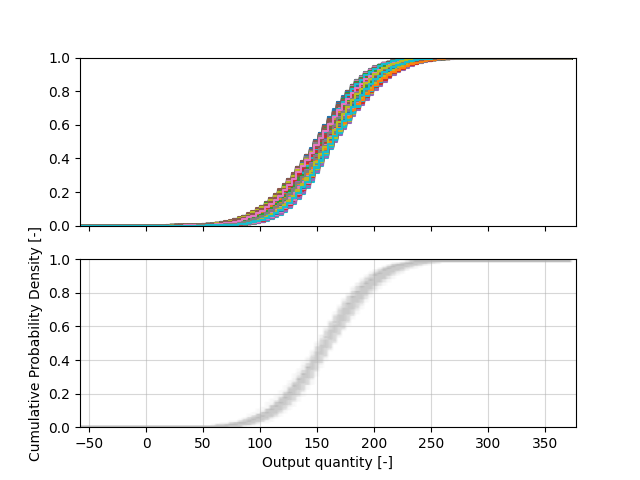

In [441]:
'''
c) p_weights do not repeat themselves (should always be changing over aleatory samples and probability is dependent on epistemic hyperparameters), 
   out repeats itself along columns (constant over epistemic samples)
   
    for each epistemic sample
       get probability weights according to epistemic variable values (polymorphy)
       compute the statistic (histogram) along aleatory samples
    for each histogram bin
        for each epistemic hypercube
            fo interval optimization -> mass belief function
        compute the other belief functions (bel, pl and q) (on probabilities)
'''
cum_dens = True

# generate the bins
# modified Freedman-Diaconis rule 
# for each epistemic sample, compute the 25% and 75% quantiles
quantiles = np.apply_along_axis(np.quantile, 1, out, [0.75,0.25])
# compute the maximum interquartile range over all epistemic samples
iqr = np.max(quantiles[:,0]) - np.min(quantiles[:,1])
# compute the bin width based on Freedman-Diaconis equation
bin_width_dens = 2 * iqr * np.power(N_mcs_ale, -1/3)
# compute the bins
start, stop= np.min(out), np.max(out)
out_range = stop - start
n_bins_dens = np.ceil(out_range / bin_width_dens).astype(int)*10
bins_densities = np.linspace(start, stop, n_bins_dens + 1) # that is what needs to be passed to histogram functions

# compute PDF/CDF for each epistemic sample
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)
densities = np.empty((n_bins_dens, N_mcs_epi))
for n_epi in range(N_mcs_epi):
    
    hist,_ = np.histogram(out[:, n_epi], bins_densities, weights=p_weights[:, n_epi], density=True)
    if cum_dens:
        hist= np.cumsum(hist)
        hist /= hist[-1]
        
    densities[:, n_epi] = hist
    ax1.step(bins_densities[:-1], hist, where='post')
    
cum_mass = not cum_dens
cum_mass = False

# compute belief functions for each aleatory bin
focals_densities = np.empty((n_bins_dens, n_hyc, 2))
n_bins_bel = np.ceil(np.sqrt(n_hyc)).astype(int)
n_bins_bel = 100
bins_bel = np.linspace(0, np.max(densities), n_bins_bel)
bel_densities = np.empty((n_bins_dens, n_bins_bel))
pl_densities = np.empty((n_bins_dens, n_bins_bel))
q_densities = np.empty((n_bins_dens, n_bins_bel))

for i_bin in range(n_bins_dens):
    # compute mass-belief functions
    hyc_out_focals = compute_out_focals(densities[i_bin, :], hyc_dat_inds)
    
    if False:
        fig, ax = plt.subplots()
        plot_focals(hyc_out_focals, hyc_mass, ax)
    focals_densities[i_bin, :, :] = hyc_out_focals
    
    # compute belief, plausibility & commonality -belief functions for each aleatory bin
    _, bel,pl,q = compute_belief(hyc_out_focals, hyc_mass, cumulative=cum_mass, bins=bins_bel)
    bel_densities[i_bin, :] = bel
    pl_densities[i_bin, :] = pl
    q_densities[i_bin, :] = q
    
    if False:
        fig, ax = plt.subplots()
        lines = plt.step(bins_bel, bel,  where='post', label='bel', ls='solid')
        c= lines[0].get_color()
        plt.step(bins_bel, pl, c=c, where='post', label='pl', ls='dashed')
        plt.step(bins_bel, q, c=c, where='post', label='q', ls='dotted')


if True:
    cmap = matplotlib.cm.get_cmap('hot_r', n_bins_bel)
    cmap = matplotlib.cm.get_cmap('Greys', n_bins_bel)
#     plt.figure()
#     plt.imshow(bel_densities.T, aspect='auto', extent=(start, stop, 0, np.max(densities)), cmap=cmap, origin='lower', vmin=0, vmax=1)
#     plt.colorbar()
#     plt.figure(tight_layout=True) 
    ax2.grid(True, alpha=0.5)
    im = ax2.imshow(pl_densities.T, aspect='auto', extent= (start, stop, 0, np.max(densities)), 
               cmap=cmap, origin='lower', vmin=0, vmax=1)
#     cbar = fig.colorbar(im)
#     cbar.set_label("Plausibility [-]")
    ax2.set_xlabel("Output quantity [-]")
    if cum_dens:
        ax2.set_ylabel("Cumulative Probability Density [-]")
    else:
        ax2.set_ylabel("Probability Density [-]")    

In [498]:

def poly_uq_qmc(mapping, vars_epi, vars_ale, arg_vars, N_mcs_ale=1000000, N_mcs_epi = 100):
    names_epi = [var.name for var in vars_epi]
    names_ale = [var.name for var in vars_ale]
    all_vars = vars_ale + vars_epi # needed to fix positions of variables for indexing/assigning/accessing corresponding sequences
#     indices_ale = [all_vars.index(var_ale) for var_ale in vars_ale]
#     indices_epi = [all_vars.index(var_epi) for var_epi in vars_epi]

    # get (truncated) support (define upper and lower bounds, e.g. 99.99 % quantiles, 0.01% quantiles) 
    supports = [var.support([0.00001, 0.99999]) for var in all_vars]

    # define equivalent uniform distributions
    vars_unif =[scipy.stats.uniform(supp[0], supp[1] - supp[0]) for supp in supports] 

    # sampling parameters
    N_vars_ale = len(vars_ale)
    N_vars_epi = len(vars_epi)
    N_vars = N_vars_ale + N_vars_epi

    N_mcs = max(N_mcs_ale,N_mcs_epi)
    
    print("Generating low-discrepancy sequences for all variables... ")
    # sample N_mcs samples from a Halton Sequence and transform to uniform bounds
    engine = scipy.stats.qmc.Halton(N_vars)
    samples = engine.random(N_mcs)
    samples = pd.DataFrame(samples, columns=[var.name for var in all_vars])
    
    for i,var in enumerate(all_vars):
        samples[var.name] = vars_unif[i].ppf(samples[var.name])

    # check the number of samples per focal set
    print("Checking sample sizes of focal sets...")
    for var in vars_epi:
        for (boundl, boundr) in var.focals:
            if isinstance(boundl, RandomVariable):
                assert isinstance(boundr, RandomVariable)
                n_samples=np.infty
                for n_ale in range(N_mcs_ale):
                    this_boundl = samples[boundl.name].iloc[n_ale]
                    this_boundr = samples[boundr.name].iloc[n_ale]
                    this_selector = np.logical_and(samples[var.name].iloc[:N_mcs_epi]>=this_boundl,
                                                   samples[var.name].iloc[:N_mcs_epi]<=this_boundr)
                    n_samples = min(np.sum(this_selector), n_samples)
                    
            else:
                this_selector = np.logical_and(samples[var.name].iloc[:N_mcs_epi]>=boundl,
                                               samples[var.name].iloc[:N_mcs_epi]<=boundr)
                n_samples = np.sum(this_selector)
            if n_samples<10:
                print(f'Warning: focal set {(boundl,boundr)} of variable {var.name} is approximated by less than ten samples.')

    # in this example: mapping function depends only on primary variables
    #     hypervariables (polymorphic inner variables) are only relevant in post-processing
    # determine, if primary variables are all the same type, or if mixed type inputs are present
    loop_ale = np.any([var.primary for var in vars_ale])
    loop_epi = np.any([var.primary for var in vars_epi])

    # generate grid indices
    print("Generating grid...")
    if loop_ale and loop_epi:
        inds_ale, inds_epi = np.mgrid[0:N_mcs_ale:1, 0:N_mcs_epi:1]
    elif loop_epi:
        inds_ale, inds_epi = np.mgrid[0:1:1, 0:N_mcs_epi:1]
    elif loop_ale:
        inds_ale, inds_epi = np.mgrid[0:N_mcs_ale:1, 0:1:1]
    else: 
        raise RuntimeError("No primary variables defined.")
    inds_alef = inds_ale.flatten()
    inds_epif = inds_epi.flatten()

    # propagation    
    print("Propagating mapping function...")
    out = np.zeros((N_mcs_ale, N_mcs_epi))
    fcount=0
    for ind_ale, ind_epi in np.nditer([inds_alef, inds_epif]):
        this_out = mapping(**{arg:samples[var].iloc[ind_ale] for arg, var in arg_vars.items() if var in names_ale}, 
                           **{arg:samples[var].iloc[ind_epi] for arg, var in arg_vars.items() if var in names_epi},)
        fcount += 1
        if loop_ale and loop_epi:
            out[ind_ale, ind_epi] = this_out
        elif loop_epi:
            out[:, ind_epi] = this_out
        elif loop_ale:
            out[ind_ale, :] = this_out
            
    if loop_ale and loop_epi:
        print(f'Mapping function was called {fcount} times in a mixed aleatory epistemic loop.')
    elif loop_ale:
        print(f'Mapping function was called {fcount} times in a pure aleatory loop.')
    elif loop_epi:
        print(f'Mapping function was called {fcount} times in a pure epistemic loop.')
    
    print("Computing aleatory probability weights...")
    # compute probabilities for approximately equally spaced bins (due to low-discrepancy sampling)
    p_weights = np.ones((N_mcs_ale, N_mcs_epi))
    
    # iterate over epistemic samples, to account for incompleteness (changing probabilities)
    if not np.all([var.primary for var in vars_epi]):
        for ind_epi in range(N_mcs_epi):

            # freeze incomplete variables
            for var in vars_epi:
                var.freeze(samples[var.name].iloc[ind_epi])
            # compute probabilities for each random variable
            for var in vars_ale:
                p_weights[:, ind_epi] *= var.mass(samples[var.name].iloc[:N_mcs_ale])
            # normalize pdf products (integration over "equally spaced" bins)
            p_weights[:, ind_epi] /= p_weights[:, ind_epi].sum()
    else:
        # compute probabilities for each random variable
        for var in vars_ale:
            p_weights[:, 0] *= var.mass(samples[var.name].iloc[:N_mcs_ale])
        # normalize pdf products (integration over "equally spaced" bins)
        p_weights[:, 0] /= p_weights[:, 0].sum()
        p_weights[:, :] = np.repeat(p_weights[:,0:1], N_mcs_epi, axis=1)
        
        
    # for imprecise variables, probabilities are not changing, with epistemic values 
    # -> p_weights are independent, not changing within epistemic loop
    print("Done... ")
    return samples, out, p_weights

In [502]:
# example b) imprecision
# interval optimization approximation with quasi MCS

# implement incremental intervals
inc_q1a1 = (RandomVariable(name='q1a1l', dist='norm', params=[15,4], primary=False),
          RandomVariable(name='dq1a1r', dist='norm', params=[0.1,0.01], primary=False),)
inc_q1a0 = (RandomVariable(name='q1a0l', dist='norm', params=[14.6,np.sqrt(4**2 + 0.06**2)], primary=False), 
          RandomVariable(name='dq1a0r', dist='norm', params=[0.9,np.sqrt(0.06**2 + 0.1**2)], primary=False))
q1 = MassFunction(name='q1', focals=[inc_q1a1, inc_q1a0], masses=[0.5,0.5], primary=True, incremental=True)

inc_q2a1 = (RandomVariable(name='q2a1l', dist='norm', params=[8,2], primary=False), 
        RandomVariable(name='dq2a1r', dist='norm', params=[0.1,0.01], primary=False))
inc_q2a0 = (RandomVariable(name='q2a0l', dist='norm', params=[7.4,np.sqrt(2**2 + 0.08**2)], primary=False), 
        RandomVariable(name='dq2a0r', dist='norm', params=[1,np.sqrt(0.08**2 + 0.11**2)], primary=False))
q2 = MassFunction(name='q2', focals=[inc_q2a1, inc_q2a0], masses=[0.5,0.5], primary=True)

vars_ale = [*inc_q1a1,*inc_q1a0,*inc_q2a1,*inc_q2a0]
vars_epi = [q1, q2]
arg_vars = {'q1':'q1', 'q2':'q2'}

N_mcs_ale = 1000
N_mcs_epi = 10000

samples, out, p_weights = poly_uq_qmc(deterministic_mapping2, vars_epi, vars_ale, arg_vars, N_mcs_ale, N_mcs_epi)

# failure probability
out_failure = out >= 260

Generating low-discrepancy sequences for all variables... 
Checking sample sizes of focal sets...
Generating grid...
Propagating mapping function...
Mapping function was called 10000 times in a pure epistemic loop.
Computing aleatory probability weights...
Done... 


In [503]:
'''
  
b) p_weights repeats itself along columns (constant over epistemic samples -> independent of imprecision), 
   out repeats itself along rows (constant over aleatory samples -> aleatory variables are all secondary)
   
   if we plot the histogram along rows, we should get a singleton
   if we plot the histogram along columns, we get a uniform distribution (p_weights do not sum to 1 though)
   
   how do we get histograms then?
   for each aleatory sample
       (compute the p_weight for that sample from the RandomVariables)
       for each imprecise hypercube
           obtain boundaries from the values of secondary aleatory variables
           do the interval optimization
        
   for each epistemic hypercube
       compute histograms for upper and lower boundary (p_weights are independent of epistemic values, so can be used)
    
   for each histogram bin
        compute the other belief functions (bel, pl and q) (on probabilities) 
'''

Pf = [1,None,0]

# alpha-level 1 (no epistemic uncertainty)
# only one epistemic hypercube <q2a1 x q1a1> 
# actually a singleton <RandomVariable('q2', norm', [14.79, 4.17]), RandomVariable('q2', norm', [8.10,2.14])>
q1a1l,q1a1r = inc_q1a1
q2a1l,q2a1r = inc_q2a1    

n_hyc = generate_hypercubes(vars_epi)[0]

intervals = np.full((N_mcs_ale, n_hyc, 2), np.nan)
for n_ale in range(N_mcs_ale):
    this_in = samples.iloc[n_ale]
    this_out = out[n_ale, :]
    this_prob = p_weights[n_ale, :] # constant
    
    # freeze the aleatory variables
    for var in vars_ale:
        print(var.name, this_in[var.name])
        var.freeze(this_in[var.name])
    
    _, hyc_foc_inds, hyc_mass, _, hyc_dat_inds = generate_hypercubes(vars_epi, samples, N_mcs_epi, False)
    
    for i_hyc in range(n_hyc):
        selector = hyc_dat_inds[i_hyc, :]
        n_samples = np.sum(selector)
        if not n_samples: continue
        this_hyc = this_out[selector]
        intervals[n_ale, i_hyc] = np.min(this_hyc),np.max(this_hyc) # that will be zero or one if out_failure is used

q1a1l 0.016166800447129592
dq1a1r 0.08786743833114707
q1a0l 14.892529386160438
dq1a0r 1.2625801856023853
q2a1l 8.524498029188118
dq2a1r 0.08225570195888303
q2a0l 0.30982045523826707
dq2a0r 1.2242347666368842
3 out of 4 hypercubes have less than ten samples for approximation of output intervals.
3 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 17.075729976140458
dq1a1r 0.07838990323353967
q1a0l 28.541715201046593
dq1a0r 0.6535588046358007
q2a1l 14.727975547622057
dq2a1r 0.0756943315066933
q2a0l 2.318432851889627
dq2a0r 0.6136159628839839
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 8.545948388293793
dq1a1r 0.1352551138191841
q1a0l 4.377196634372153
dq1a0r 0.9783702078179792
q2a1l 11.626236788405087
dq2a1r 0.14130803602859068
q2a0l 15.374413430123468
dq2a0r 0.5557678656863407
4 out of 4 hypercubes hav

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 4.3810159723530395
dq1a1r 0.07651779753524686
q1a0l 18.71430141432856
dq1a0r 1.314782018256664
q2a1l 3.025961137848947
dq2a1r 0.13777499040048852
q2a0l 5.449505117257923
dq2a0r 1.4716960713156912
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 21.440579148046368
dq1a1r 0.13338300812089127
q1a0l -1.7594773080006627
dq1a0r 0.5839563610967626
q2a1l 9.229438656282884
dq2a1r 0.10496813813953981
q2a0l 10.471036108886326
dq2a0r 1.105324789063951
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 12.910797560199702
dq1a1r 0.10495040282806907
q

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 0.6492365276701242
dq1a1r 0.1363081732744738
q1a0l 26.084861754367083
dq1a0r 1.3756841563533224
q2a1l 14.586987422203103
dq2a1r 0.08679818919501439
q2a0l 1.3732034887595757
dq2a0r 1.159789956600913
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 17.70879970336345
dq1a1r 0.1078755679816516
q1a0l 10.524789925396874
dq1a0r 0.6854599245911932
q2a1l 11.485248662986134
dq2a1r 0.10244453411946683
q2a0l 14.192876726210903
dq2a0r 1.2208518369762031
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 9.179018115516788
dq1a1r 0.07628378432296025
q

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 23.839580219628242
dq1a1r 0.13443606757618098
q1a0l 24.719943172878473
dq1a0r 0.8594660334387889
q2a1l 3.148306205361261
dq2a1r 0.10143509251143765
q2a0l 9.525806745756272
dq2a0r 1.3976099117467795
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 2.5151262500115816
dq1a1r 0.10600346228335879
q1a0l 4.246164450549246
dq1a0r 1.285781000115398
q2a1l 9.351783723795197
dq2a1r 0.12111920386800687
q2a0l 4.504275754127873
dq2a0r 0.9701767491197493
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 19.57468942570491
dq1a1r 0.07441167862466744
q1a

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 14.243575933300743
dq1a1r 0.13373402793932118
q1a0l 16.934447584067406
dq1a0r 1.2451795747176257
q2a1l 8.665486154607072
dq2a1r 0.11746968420820902
q2a0l 12.080011090979022
dq2a0r 0.5396989497981065
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 31.30313910899407
dq1a1r 0.10530142264649897
q1a0l 30.583633398953566
dq1a0r 0.9609695969332195
q2a1l 14.86896367304101
dq2a1r 0.063581032210343
q2a0l 6.999403264154994
dq2a0r 1.3945652750521669
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l -1.2166531946713337
dq1a1r 0.07370963898780762
q

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 27.571359664311156
dq1a1r 0.07546473807995714
q1a0l 2.466310620288091
dq1a0r 0.8955101559857908
q2a1l 9.06980747295729
dq2a1r 0.1336207499366761
q2a0l 7.944632627285047
dq2a0r 1.0473075453832736
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 6.246905694694497
dq1a1r 0.13232994866560155
q1a0l 16.115496435174236
dq1a0r 1.3218251226623998
q2a1l 1.3154605749148711
dq2a1r 0.09374780641952304
q2a0l 3.7362768965847053
dq2a0r 1.4136788276350138
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 23.306468870387825
dq1a1r 0.10389734337277935
q1

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 18.37518888991397
dq1a1r 0.06528516334548994
q1a0l -0.5365102589868636
dq1a0r 0.588099363688372
q2a1l 6.813997466254043
dq2a1r 0.08213922792718736
q2a0l 4.5633525893235
dq2a0r 0.7132432413910359
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 9.845407302067308
dq1a1r 0.12215037393113436
q1a0l 13.112675555899289
dq1a0r 1.05791585757688
q2a1l 12.876486859269027
dq2a1r 0.07557785747499762
q2a0l 0.54612779602078
dq2a0r 1.2017382843933564
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 26.904970477760635
dq1a1r 0.09371776863831213
q1a0l 

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 12.510964048269392
dq1a1r 0.09301572900145233
q1a0l 21.848154477426426
dq1a0r 0.9738129049672088
q2a1l 7.39076707024067
dq2a1r 0.10485166410784413
q2a0l 5.803966128431693
dq2a0r 0.9733905322973961
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 29.570527223962717
dq1a1r 0.08353819390384493
q1a0l 1.374375755097197
dq1a0r 0.7911064906772334
q2a1l 13.594244588674607
dq2a1r 0.0838863384026225
q2a0l 10.825497120060096
dq2a0r 1.4618855752997164
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 1.8487370634610611
dq1a1r 0.14040340448948935
q

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 25.039080755419178
dq1a1r 0.1421585035816389
q1a0l 5.392696058999682
dq1a0r 0.7215040471381953
q2a1l 10.197712476308915
dq2a1r 0.12201217144434039
q2a0l 14.324930828412896
dq2a0r 1.1822864388444412
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 3.714626785802519
dq1a1r 0.11372589828881666
q1a0l 19.041881873885835
dq1a0r 0.4372940693537892
q2a1l 2.4433655782664956
dq2a1r 0.06043623335455975
q2a0l 6.11325073622057
dq2a0r 1.2433483192197312
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 20.774189961495846
dq1a1r 0.0719545398956581
q1

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 30.90330559706376
dq1a1r 0.11302385865195685
q1a0l 11.452934560809133
dq1a0r 0.823007610632626
q2a1l 10.434246273499394
dq2a1r 0.06622111026211165
q2a0l 0.6191050630271444
dq2a0r 1.0087421472515117
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l -0.0171526588803963
dq1a1r 0.07000009621526444
q1a0l 25.10212037569528
dq1a0r 0.5387976328482199
q2a1l 15.086854412324849
dq2a1r 0.1341254707406907
q2a0l 2.6277174596785042
dq2a0r 1.4972371902538315
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 17.042410516812932
dq1a1r 0.12686530680090885

dq2a1r 0.09627141043959603
q2a0l 5.345251878677402
dq2a0r 0.6841500463091804
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 4.447654891008091
dq1a1r 0.12987280993659223
q1a0l 3.263423071877443
dq1a0r 0.4807955965656881
q2a1l 0.4823489247119661
dq2a1r 0.12907826270054473
q2a0l 10.366782870305807
dq2a0r 1.1726450893115006
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 21.50721806670142
dq1a1r 0.10144020464377003
q1a0l 16.912608886763586
dq1a0r 1.1913205410267032
q2a1l 5.13495706353742
dq2a1r 0.11595552179616525
q2a0l 13.734162476456614
dq2a0r 1.2337069696867906
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 0.715875446325176
dq1a1r 0.09948576096337636
q1a0l 9.214468087167806
dq1a0r 0.5010963092645743
q2a1l 5.922626260092893
dq2a1r 0.08085801357853492
q2a0l 14.265853993217268
dq2a0r 1.0055283640738648
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 17.775438622018502
dq1a1r 0.06157562057294675
q1a0l 22.863653902053954
dq1a0r 1.2116212537255893
q2a1l 12.74831583616089
dq2a1r 0.07429664312634518
q2a0l 6.467711747394339
dq2a0r 1.494023407076185
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 9.24565703417184
dq1a1r 0.11844083115859118
q1a0

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 11.111546756513297
dq1a1r 0.08930618622890915
q1a0l 6.266243951152395
dq1a0r 0.8375081197032589
q2a1l 14.24092565981113
dq2a1r 0.08439105920663709
q2a0l 15.21108335634732
dq2a0r 1.2369207528644375
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 28.171109932206626
dq1a1r 0.07982865113130175
q1a0l 19.915429766038542
dq1a0r 1.263823086379868
q2a1l 11.139186900594158
dq2a1r 0.10205628734714792
q2a0l 8.18093996806756
dq2a0r 0.6263019491115372
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 0.44931977170496795
dq1a1r 0.13669386171694617
q

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 3.1148765179070503
dq1a1r 0.11001635551627348
q1a0l 8.177129965236459
dq1a0r 0.5851992618742454
q2a1l -0.4789337485990779
dq2a1r 0.06439635043221273
q2a0l 9.53970717756701
dq2a0r 0.8609081210797567
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 20.174439693600377
dq1a1r 0.06894703675997474
q1a0l 21.826315780122606
dq1a0r 1.0318149412497406
q2a1l 4.173674390226375
dq2a1r 0.13133009397999446
q2a0l 4.518176185938609
dq2a0r 1.5293750220303002
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 11.644658105753713
dq1a1r 0.12581224734561913


4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 6.713378125279862
dq1a1r 0.09667760241593713
q1a0l 5.174309085961505
dq1a0r 0.8288078142608791
q2a1l 3.6668162533896425
dq2a1r 0.113160145035469
q2a0l 4.980365543645581
dq2a0r 0.7516394930397641
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 23.772941300973187
dq1a1r 0.05876746202550752
q1a0l 18.82349490084765
dq1a0r 0.5445978364764731
q2a1l 9.870293771823581
dq2a1r 0.08035329277452033
q2a0l 10.001896535273984
dq2a0r 1.3011964164173744
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 2.44848733135653
dq1a1r 0.11563267261115193
q1a0l

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l -1.2832921133263855
dq1a1r 0.08649802768146991
q1a0l 10.633983411915963
dq1a0r 1.18552033739845
q2a1l 15.932783164838566
dq2a1r 0.10578345636140954
q2a0l 6.7630959233724806
dq2a0r 0.4221421440894457
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 15.776271062366941
dq1a1r 0.07702049258386252
q1a0l 24.283169226802116
dq1a0r 0.901310359614044
q2a1l 5.865531895253812
dq2a1r 0.08508990339681115
q2a0l 11.951432096729715
dq2a0r 0.4832040244647357
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 7.246489474520278
dq1a1r 0.13388570316950693


4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 6.180266776039446
dq1a1r 0.07877559167601203
q1a0l 18.00454375195448
dq1a0r 1.205821050097336
q2a1l 0.22600687849568757
dq2a1r 0.1030657289551771
q2a0l 2.568640624482876
dq2a0r 1.3204791154832554
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 23.239829951732773
dq1a1r 0.13564080226165645
q1a0l 31.65372956684064
dq1a0r 0.92161107231293
q2a1l 4.87861501732114
dq2a1r 0.12274984031174634
q2a0l 15.624621202716718
dq2a0r 0.954107833231515
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 14.71004836388611
dq1a1r 0.10720819696883424
q1a0l 9

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 1.648820307495905
dq1a1r 0.13493876262479665
q1a0l 22.448718653281418
dq1a0r 1.1171607946368947
q2a1l 5.756003930052312
dq2a1r 0.060358584000095965
q2a0l 10.839397551870832
dq2a0r 0.8045823422294198
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 18.708383483189234
dq1a1r 0.10650615733197444
q1a0l 1.9749399309521891
dq1a0r 0.8329508168524885
q2a1l 13.196914417039375
dq2a1r 0.06691995445228571
q2a0l 13.911392982043498
dq2a0r 0.43821105997767995
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 10.178601895342569
dq1a1r 0.07491437367328

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 4.314377053697988
dq1a1r 0.10498507145211153
q1a0l 29.81927899331994
dq1a0r 1.1548621182205403
q2a1l 4.596638766483235
dq2a1r 0.13505726299425608
q2a0l 14.314505504554843
dq2a0r 0.7580670593950577
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 21.373940229391316
dq1a1r 0.07339328779342018
q1a0l 5.851308702379859
dq1a0r 0.8706521404361343
q2a1l 7.698377525700204
dq2a1r 0.09114655304498628
q2a0l 6.102825412362518
dq2a0r 1.3076239827726681
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 12.84415864154465
dq1a1r 0.1302584983790646
q1a0

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 16.09280592597844
dq1a1r 0.1328326437142172
q1a0l 13.167272299158833
dq1a0r 0.9315542785327926
q2a1l 3.4687337631316093
dq2a1r 0.1099944405842532
q2a0l 2.617292135820452
dq2a0r 0.7917272095188325
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 7.563024338131775
dq1a1r 0.104400038421395
q1a0l 26.816458114044984
dq1a0r 1.3578692452094019
q2a1l 9.672211281565547
dq2a1r 0.07718758832330452
q2a0l 15.673272714054292
dq2a0r 0.42535592726709254
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 24.622587513825103
dq1a1r 0.0664898980309654
q1a0

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 30.486812355469684
dq1a1r 0.12183402273674691
q1a0l 15.078158313242893
dq1a0r 0.6183432826071208
q2a1l 15.625172709379031
dq2a1r 0.10679289796943872
q2a0l -0.6910106351347287
dq2a0r 0.9605353995868088
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l -0.43364590047447193
dq1a1r 0.09340141744392469
q1a0l 28.727344128129047
dq1a0r 1.0040568238859575
q2a1l 6.460944557147077
dq2a1r 0.08862294902491331
q2a0l 9.352051348122073
dq2a0r 1.0826591603373892
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 16.625917275218857
dq1a1r 0.0839238823463

q2a0l 7.4615926218619695
dq2a0r 0.5217694225964978
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 21.690475093002814
dq1a1r 0.1400870532951019
q1a0l 12.129934177227486
dq1a0r 0.7807489841982098
q2a1l 8.575766438431375
dq2a1r 0.05851291857476448
q2a0l 11.242510074382176
dq2a0r 1.3766357478505582
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 13.160693505156148
dq1a1r 0.1116544480022797
q1a0l 25.779119992113635
dq1a0r 0.4965390064138039
q2a1l 14.779243956865312
dq2a1r 0.06507428902695422
q2a0l 5.452980225210606
dq2a0r 0.7049550637223678
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q

4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 9.428914060473232
dq1a1r 0.07163818870127066
q1a0l 3.9404226882957953
dq1a0r 0.41823625743238585
q2a1l 9.280707065526139
dq2a1r 0.09434809565980076
q2a0l 1.3766785967122597
dq2a0r 1.440911411403495
3 out of 4 hypercubes have less than ten samples for approximation of output intervals.
2 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 26.48847723616656
dq1a1r 0.12850339928691507
q1a0l 17.589608503181942
dq1a0r 1.128761201893401
q2a1l 1.5263601674837184
dq2a1r 0.12715494792074944
q2a0l 14.196351834163586
dq2a0r 1.0134782487764649
4 out of 4 hypercubes have less than ten samples for approximation of output intervals.
4 out of 4 hypercubes are empty. For safety, mass has been removed (open-world assumption).
q1a1l 5.1640232665499015
dq1a1r 0.10007079399409287


KeyboardInterrupt: 

In [476]:

focals_Pf = np.empty((n_hyc, 2))
for i_hyc in range(n_hyc):
    for j in range(2):
        failed = (p_weights[:, 0][intervals[:, i_hyc, j]==1]).sum()
        focals_Pf[i_hyc, j] = failed
#         hist,_ = np.histogram(intervals[:, i_hyc, j], 
#                               bins_densities, 
#                               weights=p_weights[:, 0], # constant over epistemic columns
#                               density=True)
#         if cum_dens:
#             hist= np.cumsum(hist)

#             hist /= hist[-1]

#         focals_densities[:, i_hyc, j] = hist
    

In [ ]:
pd.set_option('display.max_columns', None)
#  by iterating over epistemic input hypercubes

n_hyc, hyc_foc_inds, hyc_mass, hyc_ovrvw, hyc_dat_inds = generate_hypercubes(vars_epi, samples, N_mcs_epi)

for i_hyc in range(n_hyc):
    selector = hyc_dat_inds[i_hyc, :]
    n_samples = np.sum(selector)
    if not n_samples: continue
    # walk over samples, evaluate output variable and compute output interval for this hypercube
    Pf = [1, 0]
    
    Pf_ = Pfs[selector]

    if np.min(Pf_) < Pf[0]: 
        Pf[0] = np.min(Pf_)
    else:
        Pf[0] = np.nan
        
    if np.max(Pf_) > Pf[1]: 
        Pf[1] = np.max(Pf_)
    else:
        Pf[1] = np.nan
    
    hyc_ovrvw.iloc[-2,2 * i_hyc:2 * i_hyc + 2] = Pf
    hyc_ovrvw.iloc[-1,2*i_hyc] = n_samples

hyc_ovrvw.iloc[-2,:]*=1e4
s2 = hyc_ovrvw.style.applymap(lambda x: 'background-color : yellow' if np.isnan(x) else '')
display(s2)

In [404]:

p_weights, out

(array([[6.57154775e-08, 6.57154775e-08, 6.57154775e-08, ...,
         6.57154775e-08, 6.57154775e-08, 6.57154775e-08],
        [1.86234524e-05, 1.86234524e-05, 1.86234524e-05, ...,
         1.86234524e-05, 1.86234524e-05, 1.86234524e-05],
        [4.93124684e-13, 4.93124684e-13, 4.93124684e-13, ...,
         4.93124684e-13, 4.93124684e-13, 4.93124684e-13],
        ...,
        [5.32252214e-08, 5.32252214e-08, 5.32252214e-08, ...,
         5.32252214e-08, 5.32252214e-08, 5.32252214e-08],
        [1.47815539e-15, 1.47815539e-15, 1.47815539e-15, ...,
         1.47815539e-15, 1.47815539e-15, 1.47815539e-15],
        [1.03481105e-10, 1.03481105e-10, 1.03481105e-10, ...,
         1.03481105e-10, 1.03481105e-10, 1.03481105e-10]]),
 array([[103.30563383, 193.13998812, 206.93379446, ..., 253.4438486 ,
         108.50204299, 118.87680594],
        [103.30563383, 193.13998812, 206.93379446, ..., 253.4438486 ,
         108.50204299, 118.87680594],
        [103.30563383, 193.13998812, 206.93379446

In [ ]:
'''
expected outcome for d)
primary variables are imprecise: q1, q2
secondary variables are variable: q1a0,q1a1, ...
tertiary variables are incomplete: muq1a0, sigmaq1a0, mu1q1a1, sigmaq1a1, ....
d) p_weights do not repeat themselves (should be changing over aleatory samples and be dependent on epistemic samples due to incompleteness)
   out repeats itself along rows (independent of aleatory variables)
   
   hier beisst sich die katze in den schwanz!
   we cannot compute histograms because no aleatory variable is primary
   p_weights get lost in interval optimization
       
   for each aleatory sample
       for each imprecise hypercube
           obtain boundaries from the values of aleatory variable
           do the interval optimization
           store p_weights for upper and lower bounds
               now we have a mixed imprecise/incomplete interval optimization, 
               where probability weights depend on part of the input variables
               that results in non-normalized probability weights
               
               if we do it in a threefold loop, 
                   we start with epistemic interval optimization, 
                       within which several MCS are caried out (changing probabilities for the same values)
                           another epistemic interval optimization is done and an interval is returned to the MCS
                           both boundaries of this interval have a fixed probability
                       an interval-valued statistic is returned (upper/lower statistic) from the MCS
                   the interval optimization on multiple upper/lower statistics returns again upper/lower statistic and discards all intermediate statistics
                   it merges imprecision with incompleteness -> a distinction is not necessary and better be answered by sensitivity analysis
                
                now transfering that to 2D sampling
                boundaries already reflect merged epistemic characteristics
                boundaries have non-equal probabilities
                statistic can not be computed properly
                
                   
               
           
        
    for each epistemic hypercube
        compute histograms for upper and lower boundary
    
    for each histogram bin
        compute the other belief functions (bel, pl and q) (on probabilities)    

e) mixed aleatory and epistemic primary variables
   p_weights do not repeat themselves (should be changing over aleatory samples and be dependent on epistemic samples due to incompleteness)
   out does not repeat itself (both aleatory and epistemic variables)
   
   
'''